In [1]:
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

from itertools import chain
import collections

from nltk.corpus import stopwords

In [2]:
df_bbc = pd.read_csv('tweets_bbc.csv',low_memory=False)
df_cnn = pd.read_csv('tweets_cnn.csv',low_memory=False)
df_eco = pd.read_csv('tweets_eco.csv',low_memory=False)

In [3]:
df_tweets = pd.concat([df_bbc, df_cnn, df_eco])

In [4]:
df_tweets = df_tweets.reset_index(drop=True)

In [5]:
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [6]:
tweets_nu = pd.DataFrame([remove_url(str(tweet)) for tweet in df_tweets['tweet']], columns=['tweet'])

In [7]:
df_tweets['tweet_length'] = tweets_nu['tweet'].str.len()

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dheeraj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
stop_words = set(stopwords.words('english'))

In [10]:
tweet_words = [tweet.lower().split() for tweet in tweets_nu['tweet']]

In [11]:
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in tweet_words]

In [12]:
all_words = list(chain(*tweets_nsw))
word_counts = collections.Counter(all_words)

df_mcw = pd.DataFrame(word_counts.most_common(15), columns=['words','count'])

In [13]:
tweet_hashtags = [str(hashtags).replace('[','').replace(']','').replace('\'','') for hashtags in df_tweets['hashtags'] if not '[]' in str(hashtags)]

In [14]:
hashtag_count = collections.Counter(tweet_hashtags)

df_mch = pd.DataFrame(hashtag_count.most_common(15), columns=['hashtags','count'])

In [15]:
df_tweets['tweet_mcw'] = False
df_tweets['tweet_mch'] = False

In [16]:
for i in df_mcw.index:
    index = df_tweets['tweet'].str.contains(df_mcw['words'][i])
    value = df_tweets[index]['tweet']
    df_tweets.loc[index, 'tweet_mcw'] = True

In [17]:
for i in df_mch.index:
    index = df_tweets['hashtags'].str.contains(df_mch['hashtags'][i])
    value = df_tweets[index]['hashtags']
    df_tweets.loc[index, 'tweet_mch'] = True

In [18]:
df_tweets_mc = df_tweets[(df_tweets['tweet_mcw'] == True) | (df_tweets['tweet_mch'] == True)].sample(n=1000)

In [19]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dheeraj/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [20]:
def percentage(part,whole):
 return 100 * float(part)/float(whole)

In [21]:
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []
noOfTweet = len(df_tweets_mc)

In [22]:
for tweet in df_tweets_mc['tweet']:
    tweet_list.append(tweet)
    analysis = TextBlob(tweet)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity
    if neg > pos:
        negative_list.append(tweet)
        negative += 1
    elif pos > neg:
        positive_list.append(tweet)
        positive += 1
    elif pos == neg:
        neutral_list.append(tweet)
        neutral += 1

In [23]:
positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

In [24]:
tweet_list = pd.DataFrame(tweet_list,columns=['tweet'])
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("total number: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

total number:  1000
positive number:  309
negative number:  428
neutral number:  263


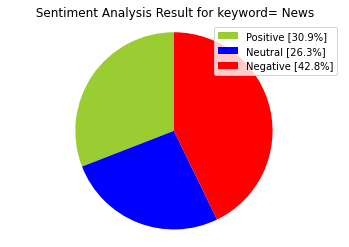

In [25]:
labels = ['Positive ['+str(positive)+'%]', 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title(" Sentiment Analysis Result for keyword= News " )
plt.axis('equal')
plt.show()

In [26]:
tweet_list.drop_duplicates(inplace = True)

In [27]:
#Calculating Negative, Positive, Neutral and Compound values
tweet_list[['polarity', 'subjectivity']] = tweet_list['tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tweet_list['tweet'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tweet_list.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tweet_list.loc[index, 'sentiment'] = "positive"
    else:
        tweet_list.loc[index, 'sentiment'] = "neutral"
    tweet_list.loc[index, 'neg'] = neg
    tweet_list.loc[index, 'neu'] = neu
    tweet_list.loc[index, 'pos'] = pos
    tweet_list.loc[index, 'compound'] = comp


In [28]:
tw_list_negative = tweet_list[tweet_list["sentiment"]=="negative"]
tw_list_positive = tweet_list[tweet_list["sentiment"]=="positive"]
tw_list_neutral = tweet_list[tweet_list["sentiment"]=="neutral"]

In [29]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
pc = count_values_in_column(tweet_list,"sentiment")

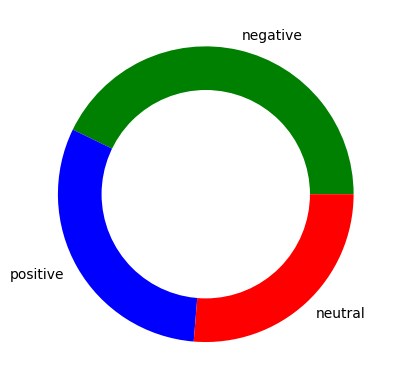

In [30]:
# create data for Pie Chart
pichart = count_values_in_column(tweet_list,"sentiment")
names= pc.index
size=pc["Percentage"]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [60]:
tweet_list

,tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,A policing bill named after George Floyd has p...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
1,Massachusetts Gov. Baker says all nonessential...,0.368182,0.650000,positive,0.000,0.846,0.154,0.4767
2,The inside story of the NHS’s struggle against...,0.000000,0.000000,negative,0.173,0.827,0.000,-0.3182
3,"Escalation between Armenia and Azerbaijan, or ...",0.000000,0.000000,negative,0.134,0.756,0.110,-0.1027
4,Bacalhau is one of Portugal’s favourite comfor...,0.000000,0.000000,positive,0.000,0.800,0.200,0.3612
...,...,...,...,...,...,...,...,...
995,"It is widely known that bacon is a treat, not ...",0.018182,0.427273,positive,0.000,0.870,0.130,0.4019
996,Women in other countries often withdraw from t...,0.187500,0.437500,negative,0.263,0.737,0.000,-0.7579
997,A ferry is in difficulty at Parkeston Quay in ...,0.000000,0.400000,negative,0.106,0.837,0.057,-0.2732
998,Tanzania's new president could make a good sta...,0.418182,0.527273,negative,0.146,0.730,0.124,-0.1280


In [63]:
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


from  nltk.stem import SnowballStemmer


# Word2vec
import gensim


from collections import Counter
import logging
import time
import pickle

In [64]:
df_train, df_test = train_test_split(tweet_list, test_size=1-0.8, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 800
TEST size: 200


In [65]:
documents = [_text.split() for _text in df_train['tweet']] 

In [66]:
# WORD2VEC 
W2V_SIZE = 100
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

In [67]:
w2v_model = gensim.models.word2vec.Word2Vec(window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [68]:
w2v_model.wv.most_similar(positive="election")

KeyError: "Key 'election' not present"

In [69]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['tweet'])

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 5766


In [70]:
# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 500

In [71]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train['tweet']), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test['tweet']), maxlen=SEQUENCE_LENGTH)

In [72]:
df_train['sentiment'].unique().tolist()

['positive', 'neutral', 'negative']

In [73]:
encoder = LabelEncoder()
encoder.fit(df_train['sentiment'].tolist())

y_train = encoder.transform(df_train['sentiment'].tolist())
y_test = encoder.transform(df_test['sentiment'].tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (800, 1)
y_test (200, 1)


In [74]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (800, 300)
y_train (800, 1)

x_test (200, 300)
y_test (200, 1)


In [75]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(5766, 100)


In [76]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [77]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          576600    
                                                                 
 dropout_1 (Dropout)         (None, 300, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 657,101
Trainable params: 80,501
Non-trainable params: 576,600
_________________________________________________________________


In [78]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [79]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [80]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
2/2 [==============================] - 6s 1s/step - loss: 0.6918 - accuracy: 0.3653 - val_loss: 0.6788 - val_accuracy: 0.2125 - lr: 0.0010
Epoch 2/8
2/2 [==============================] - 3s 1s/step - loss: 0.6815 - accuracy: 0.2736 - val_loss: 0.6590 - val_accuracy: 0.2125 - lr: 0.0010
Epoch 3/8
2/2 [==============================] - 3s 1s/step - loss: 0.6673 - accuracy: 0.2736 - val_loss: 0.6287 - val_accuracy: 0.2125 - lr: 0.0010
Epoch 4/8
2/2 [==============================] - 3s 1s/step - loss: 0.6463 - accuracy: 0.2736 - val_loss: 0.5761 - val_accuracy: 0.2125 - lr: 0.0010
Epoch 5/8
2/2 [==============================] - 3s 1s/step - loss: 0.6070 - accuracy: 0.2736 - val_loss: 0.4625 - val_accuracy: 0.2125 - lr: 0.0010
Epoch 6/8
2/2 [==============================] - 3s 1s/step - loss: 0.5194 - accuracy: 0.2736 - val_loss: 0.0613 - val_accuracy: 0.2125 - lr: 0.0010


In [81]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

1/1 [==============================] - 0s 216ms/step - loss: 0.3768 - accuracy: 0.2450

ACCURACY: 0.24500000476837158
LOSS: 0.37677133083343506


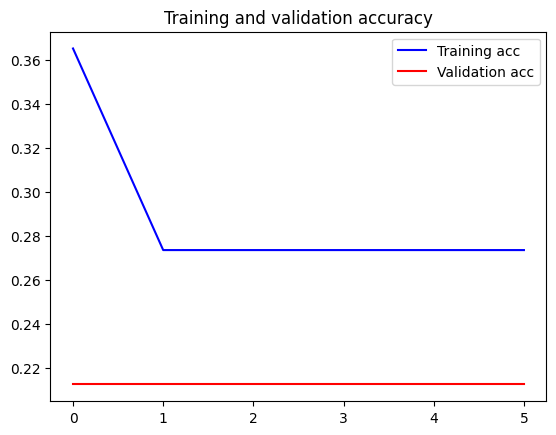

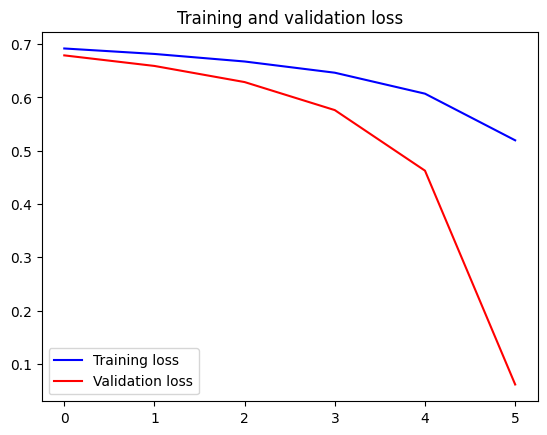

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [83]:
SENTIMENT_THRESHOLDS = (0.4, 0.7)
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = 'NEGATIVE'
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = 'POSITIVE'

        return label
    else:
        return 'NEGATIVE' if score < 0.5 else 'POSITIVE'

In [84]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    print(score)
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [85]:
predict("I love the music")

[0.87448967]


{'label': 'POSITIVE',
 'score': 0.8744896650314331,
 'elapsed_time': 0.3518486022949219}

In [86]:
predict("I hate the rain")

[0.87448967]


{'label': 'POSITIVE',
 'score': 0.8744896650314331,
 'elapsed_time': 0.10097765922546387}

In [55]:
y_pred_1d = []
y_test_1d = list(df_test['sentiment'])
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 1s 583ms/step


In [56]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

/tmp/ipykernel_3103/106037557.py:9: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


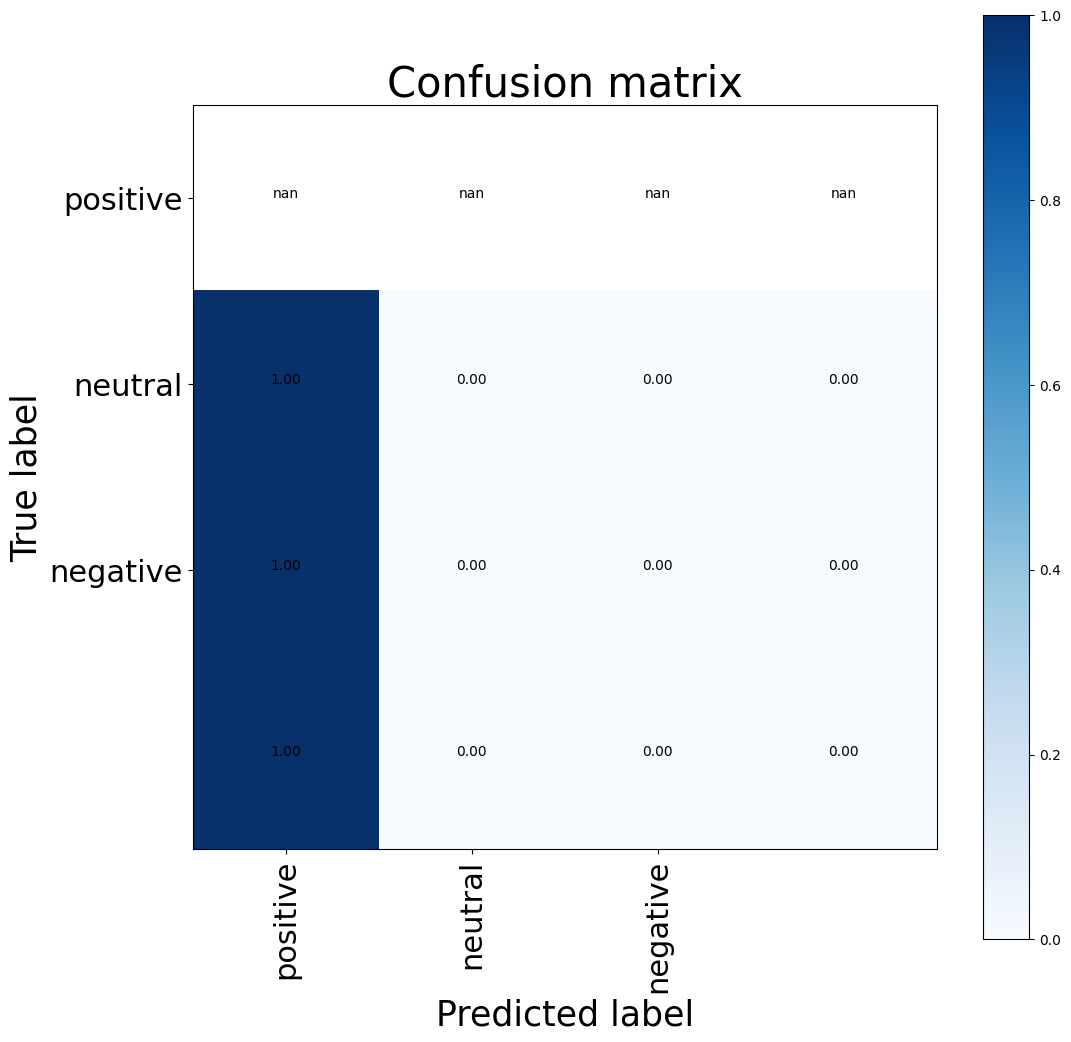

In [57]:
import itertools

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train['sentiment'].unique(), title="Confusion matrix")
plt.show()

In [58]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    POSITIVE       0.00      0.00      0.00       0.0
    negative       0.00      0.00      0.00      88.0
     neutral       0.00      0.00      0.00      49.0
    positive       0.00      0.00      0.00      63.0

    accuracy                           0.00     200.0
   macro avg       0.00      0.00      0.00     200.0
weighted avg       0.00      0.00      0.00     200.0



/home/dheeraj/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dheeraj/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dheeraj/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dheeraj/.local/lib/python3.8/site-packa

In [59]:
accuracy_score(y_test_1d, y_pred_1d)

0.0